<a href="https://colab.research.google.com/github/0Nguyen0Cong0Tuan0/Road-Buddy-Challenge/blob/main/models/yolo_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLO11 Fine-tuned Models Benchmark**

This notebook **benchmarks and evaluates** all 6 fine-tuned YOLO models:

| Model | Training | Description |
|-------|----------|-------------|
| yolo11n_road_lane | Road Lane only | Nano model for lane detection |
| yolo11l_road_lane | Road Lane only | Large model for lane detection |
| yolo11n_bdd100k | BDD100K only | Nano model for traffic objects |
| yolo11l_bdd100k | BDD100K only | Large model for traffic objects |
| yolo11n_unified | Road Lane -> BDD100K | Nano model for unified datasets |
| yolo11l_unified | Road Lane -> BDD100K | Large model for unified datasets |

## **Setup & Installation**

In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.9 MB/s eta 0:00:00a 0:00:01


In [2]:
import ultralytics
import os
import yaml
import time
from collections import Counter
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import shutil
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


In [12]:
# Dataset paths (Kaggle input datasets)
DATA_DIR = Path('/kaggle/input/')

# Fine-tuned models path
MODELS_DIR = Path('/kaggle/input/all-models/pytorch/default/1')

# Dataset configurations
DATASETS = {
    'bdd100k': {
        'path': DATA_DIR / 'bdd100ka',
        'yaml': DATA_DIR / 'bdd100ka' / 'data_yolo.yaml',
        'description': 'BDD100K - Vehicles, pedestrians, traffic objects',
        'classes': ['bike', 'bus', 'car', 'drivable area', 'lane', 'motor',
                   'person', 'rider', 'traffic light', 'traffic sign', 'train', 'truck']
    },
    'road_lane': {
        'path': DATA_DIR / 'roadlaneds' / 'Road Lane.v2i.yolo26',
        'yaml': DATA_DIR / 'roadlaneds' /'Road Lane.v2i.yolo26' / 'data.yaml',
        'description': 'Road Lane v2 - Lane line types',
        'classes': ['divider-line', 'dotted-line', 'double-line',
                   'random-line', 'road-sign-line', 'solid-line']
    }
}

for name, info in DATASETS.items():
    exists = info['path'].exists()
    yaml_exists = info['yaml'].exists()
    print(f"\n{name}: {info['path'].name}")
    print(f"   Path: {info['path']} ({'found' if exists else 'NOT FOUND'})")
    print(f"   YAML: {info['yaml'].name} ({'found' if yaml_exists else 'NOT FOUND'})")
    print(f"   Classes: {len(info['classes'])} - {info['classes']}")


bdd100k: bdd100ka
   Path: /kaggle/input/bdd100ka (found)
   YAML: data_yolo.yaml (found)
   Classes: 12 - ['bike', 'bus', 'car', 'drivable area', 'lane', 'motor', 'person', 'rider', 'traffic light', 'traffic sign', 'train', 'truck']

road_lane: Road Lane.v2i.yolo26
   Path: /kaggle/input/roadlaneds/Road Lane.v2i.yolo26 (found)
   YAML: data.yaml (found)
   Classes: 6 - ['divider-line', 'dotted-line', 'double-line', 'random-line', 'road-sign-line', 'solid-line']


## **Load Fine-tuned Models for Evaluation**

In [13]:
def find_best_weights(model_dir):
    """Find the best.pt weights file in a model directory."""
    weights_path = model_dir / 'weights' / 'best.pt'
    if weights_path.exists():
        return weights_path
    return None

# Collect all trained models (6 total)
FINETUNED_MODELS = {}

model_runs = [
    # Single dataset models
    ('YOLO11n_RoadLane', MODELS_DIR / 'yolo11n_road_lane'),
    ('YOLO11l_RoadLane', MODELS_DIR / 'yolo11l_road_lane'),
    ('YOLO11n_BDD100K', MODELS_DIR / 'yolo11n_bdd100k'),
    ('YOLO11l_BDD100K', MODELS_DIR / 'yolo11l_bdd100k'),
    # Sequential training models (Road Lane -> BDD100K)
    ('YOLO11n_Unified', MODELS_DIR / 'yolo11n_unified'),
    ('YOLO11l_Unified', MODELS_DIR / 'yolo11l_unified'),
]

print("Loading Fine-tuned Models:")
print("=" * 50)
for name, model_dir in model_runs:
    weights = find_best_weights(model_dir)
    if weights:
        try:
            model = YOLO(weights)
            FINETUNED_MODELS[name] = {
                'model': model,
                'path': weights,
                'classes': list(model.names.values())
            }
            print(f"{name}: Loaded ({len(model.names)} classes)")
        except Exception as e:
            print(f"{name}: Failed to load - {e}")
    else:
        print(f"{name}: Not found at {model_dir}")

print(f"\nTotal models loaded: {len(FINETUNED_MODELS)}/6")

Loading Fine-tuned Models:
YOLO11n_RoadLane: Loaded (6 classes)
YOLO11l_RoadLane: Loaded (6 classes)
YOLO11n_BDD100K: Loaded (12 classes)
YOLO11l_BDD100K: Loaded (12 classes)
YOLO11n_Unified: Loaded (17 classes)
YOLO11l_Unified: Loaded (17 classes)

Total models loaded: 6/6


In [14]:
# Load pre-trained models for comparison
PRETRAINED_MODELS = {
    'YOLO11n_Pretrained': YOLO('yolo11n.pt'),
    'YOLO11l_Pretrained': YOLO('yolo11l.pt'),
}

print("Pre-trained models (COCO):")
for name, model in PRETRAINED_MODELS.items():
    print(f"   {name}: {len(model.names)} classes")

Pre-trained models (COCO):
   YOLO11n_Pretrained: 80 classes
   YOLO11l_Pretrained: 80 classes


## **Performance Evaluation**

Compare fine-tuned models against pre-trained models.

### **Inference Speed Test**

In [15]:
def benchmark_inference(model, images, model_name, num_runs=3, warmup=2):
    """
    Benchmark inference speed of a model.
    """
    times = []
    detections = []
    confidences = []
    class_counts = Counter()

    # Warmup
    for _ in range(warmup):
        if images:
            _ = model(images[0], verbose=False)

    # Benchmark
    for _ in range(num_runs):
        for img in images:
            start = time.time()
            results = model(img, verbose=False)
            inference_time = (time.time() - start) * 1000
            times.append(inference_time)

            for r in results:
                n_det = len(r.boxes)
                detections.append(n_det)
                if n_det > 0:
                    confs = r.boxes.conf.cpu().numpy()
                    confidences.extend(confs.tolist())
                    for cls_id in r.boxes.cls.cpu().numpy().astype(int):
                        class_counts[model.names[cls_id]] += 1

    return {
        'model_name': model_name,
        'avg_time_ms': np.mean(times),
        'std_time_ms': np.std(times),
        'fps': 1000 / np.mean(times),
        'avg_detections': np.mean(detections),
        'avg_confidence': np.mean(confidences) if confidences else 0,
        'class_counts': dict(class_counts),
        'total_detections': sum(class_counts.values())
    }

In [17]:
# Get test images from Road Lane dataset
road_lane_test_dir = DATASETS['road_lane']['path'] / 'test' / 'images'
test_images_lane = list(road_lane_test_dir.glob('*.jpg'))[:20] if road_lane_test_dir.exists() else []
print(f"Road Lane test images: {len(test_images_lane)}")

# Get validation images from BDD100K (new structure)
bdd_val_dir = DATASETS['bdd100k']['path'] / 'valid' / 'images'
test_images_bdd = list(bdd_val_dir.glob('*.jpg'))[:20] if bdd_val_dir.exists() else []
print(f"BDD100K validation images: {len(test_images_bdd)}")

# Combined test images
all_test_images = test_images_lane + test_images_bdd
print(f"Combined test set: {len(all_test_images)} images")

Road Lane test images: 20
BDD100K validation images: 20
Combined test set: 40 images


In [18]:
# Run benchmarks on Road Lane test set
print("Benchmarking on Road Lane Test Set")
benchmark_results = {}

if test_images_lane:
    # Benchmark fine-tuned models
    for name, info in FINETUNED_MODELS.items():
        if 'RoadLane' in name:  # Only Road Lane models
            print(f"\nBenchmarking {name}...")
            benchmark_results[name] = benchmark_inference(
                info['model'], test_images_lane, name, num_runs=2
            )

    # Benchmark pre-trained models for comparison
    for name, model in PRETRAINED_MODELS.items():
        print(f"\nBenchmarking {name}...")
        benchmark_results[name] = benchmark_inference(
            model, test_images_lane, name, num_runs=2
        )
else:
    print("No Road Lane test images found!")

Benchmarking on Road Lane Test Set

Benchmarking YOLO11n_RoadLane...

Benchmarking YOLO11l_RoadLane...

Benchmarking YOLO11n_Pretrained...

Benchmarking YOLO11l_Pretrained...


In [19]:
# Display benchmark results
if benchmark_results:
    comparison_data = []
    for name, result in benchmark_results.items():
        comparison_data.append({
            'Model': name,
            'Avg Time (ms)': f"{result['avg_time_ms']:.1f}",
            'FPS': f"{result['fps']:.1f}",
            'Avg Detections': f"{result['avg_detections']:.1f}",
            'Avg Confidence': f"{result['avg_confidence']:.2%}",
            'Total Detections': result['total_detections']
        })

    df_results = pd.DataFrame(comparison_data)
    print(df_results.to_string(index=False))
else:
    print("No benchmark results to display.")

             Model Avg Time (ms)  FPS Avg Detections Avg Confidence  Total Detections
  YOLO11n_RoadLane          19.1 52.2            7.5         74.50%               300
  YOLO11l_RoadLane          31.8 31.4            7.7         76.74%               308
YOLO11n_Pretrained          13.0 77.2            5.7         58.47%               228
YOLO11l_Pretrained          32.0 31.2            7.5         59.71%               300


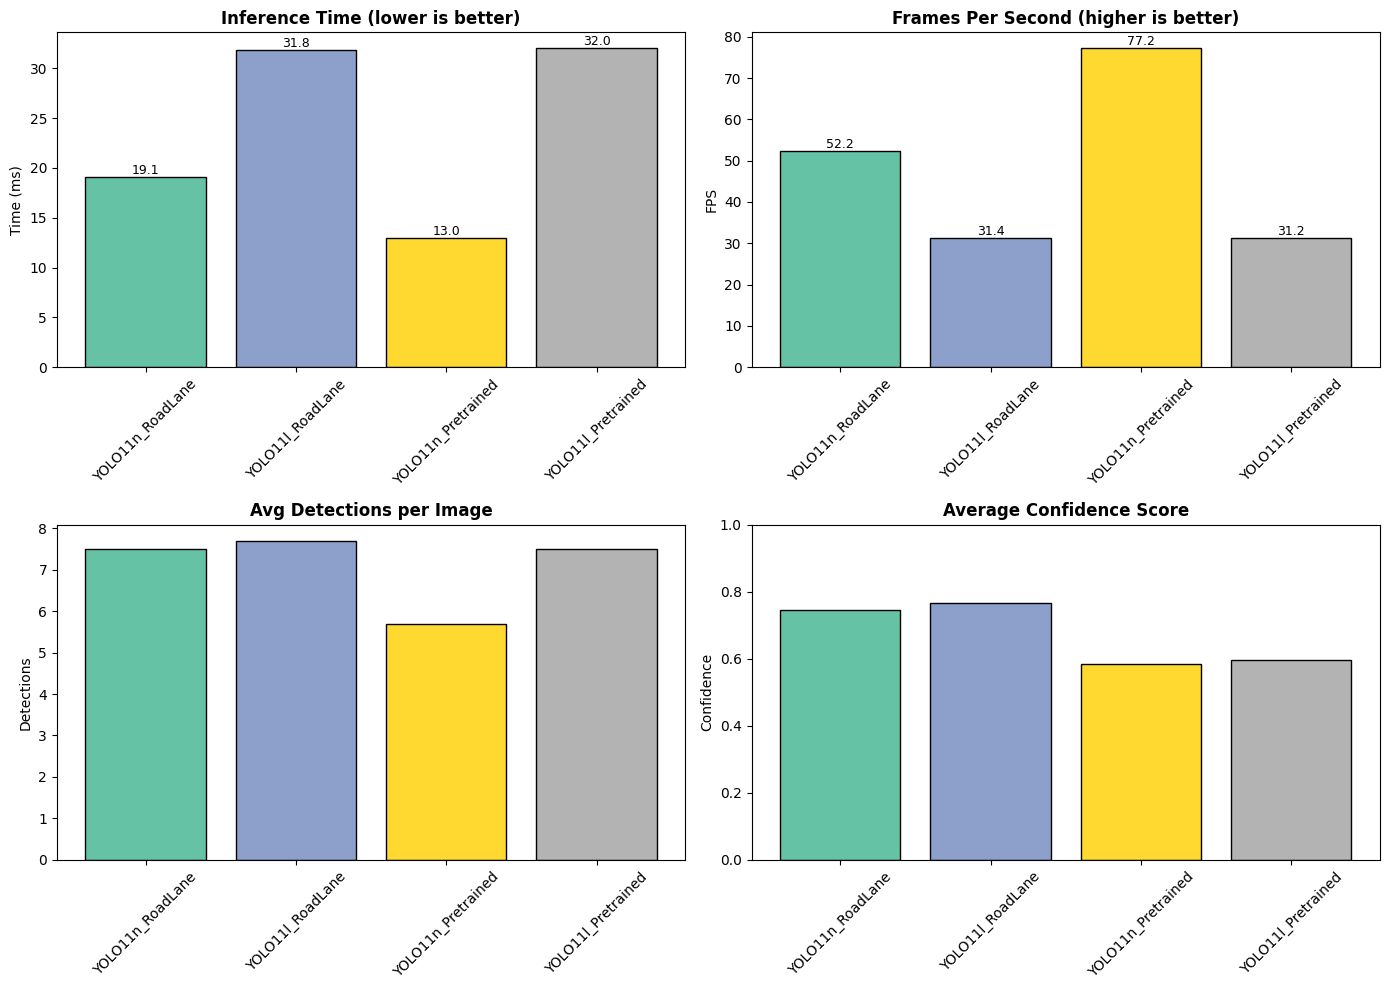

In [20]:
if benchmark_results:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    models = list(benchmark_results.keys())
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

    # Inference Time
    ax = axes[0, 0]
    times = [benchmark_results[m]['avg_time_ms'] for m in models]
    bars = ax.bar(models, times, color=colors, edgecolor='black')
    ax.set_ylabel('Time (ms)')
    ax.set_title('Inference Time (lower is better)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    for bar, t in zip(bars, times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{t:.1f}', ha='center', va='bottom', fontsize=9)

    # FPS
    ax = axes[0, 1]
    fps = [benchmark_results[m]['fps'] for m in models]
    bars = ax.bar(models, fps, color=colors, edgecolor='black')
    ax.set_ylabel('FPS')
    ax.set_title('Frames Per Second (higher is better)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    for bar, f in zip(bars, fps):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{f:.1f}', ha='center', va='bottom', fontsize=9)

    # Average Detections
    ax = axes[1, 0]
    dets = [benchmark_results[m]['avg_detections'] for m in models]
    bars = ax.bar(models, dets, color=colors, edgecolor='black')
    ax.set_ylabel('Detections')
    ax.set_title('Avg Detections per Image', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

    # Average Confidence
    ax = axes[1, 1]
    confs = [benchmark_results[m]['avg_confidence'] for m in models]
    bars = ax.bar(models, confs, color=colors, edgecolor='black')
    ax.set_ylabel('Confidence')
    ax.set_title('Average Confidence Score', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

## **Detection Quality Test**

In [21]:
# Define traffic vs non-traffic classes for relevance analysis
TRAFFIC_CLASSES = {
    'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle',
    'person', 'traffic light', 'stop sign', 'parking meter',
    'lane', 'drivable area', 'road', 'rider', 'motor', 'bike',
    'divider-line', 'dotted-line', 'double-line', 'random-line',
    'road-sign-line', 'solid-line', 'traffic sign'
}

NON_TRAFFIC_CLASSES = {
    'toothbrush', 'hair drier', 'wine glass', 'cup', 'fork', 'knife',
    'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'couch', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket'
}

print(f"Traffic-related classes: {len(TRAFFIC_CLASSES)}")
print(f"Non-traffic classes: {len(NON_TRAFFIC_CLASSES)}")

Traffic-related classes: 23
Non-traffic classes: 47


In [22]:
def analyze_detection_relevance(model, images, model_name):
    """
    Analyze what classes the model detects and categorize them.
    """
    traffic_detections = Counter()
    non_traffic_detections = Counter()
    other_detections = Counter()

    for img in images:
        results = model(img, verbose=False)
        for r in results:
            for cls_id in r.boxes.cls.cpu().numpy().astype(int):
                class_name = model.names[cls_id]
                if class_name.lower() in {c.lower() for c in TRAFFIC_CLASSES}:
                    traffic_detections[class_name] += 1
                elif class_name.lower() in {c.lower() for c in NON_TRAFFIC_CLASSES}:
                    non_traffic_detections[class_name] += 1
                else:
                    other_detections[class_name] += 1

    total = sum(traffic_detections.values()) + sum(non_traffic_detections.values()) + sum(other_detections.values())

    return {
        'model_name': model_name,
        'traffic_detections': dict(traffic_detections),
        'non_traffic_detections': dict(non_traffic_detections),
        'other_detections': dict(other_detections),
        'traffic_count': sum(traffic_detections.values()),
        'non_traffic_count': sum(non_traffic_detections.values()),
        'other_count': sum(other_detections.values()),
        'total': total,
        'traffic_ratio': sum(traffic_detections.values()) / max(total, 1)
    }

In [23]:
relevance_results = {}

# Use combined test images for analysis
test_images = all_test_images[:15] if all_test_images else test_images_lane[:15]

if test_images:    
    # Analyze fine-tuned models
    for name, info in FINETUNED_MODELS.items():
        print(f"\nAnalyzing {name}...")
        relevance_results[name] = analyze_detection_relevance(
            info['model'], test_images, name
        )

    # Analyze pre-trained models
    for name, model in PRETRAINED_MODELS.items():
        print(f"\nAnalyzing {name}...")
        relevance_results[name] = analyze_detection_relevance(
            model, test_images, name
        )
else:
    print("No test images found for analysis!")


Analyzing YOLO11n_RoadLane...

Analyzing YOLO11l_RoadLane...

Analyzing YOLO11n_BDD100K...

Analyzing YOLO11l_BDD100K...

Analyzing YOLO11n_Unified...

Analyzing YOLO11l_Unified...

Analyzing YOLO11n_Pretrained...

Analyzing YOLO11l_Pretrained...


In [24]:
# Display relevance results
for name, result in relevance_results.items():
    print(f"\n{name}")
    print(f"   Traffic-related detections: {result['traffic_count']}")
    print(f"   Non-traffic detections: {result['non_traffic_count']}")
    print(f"   Other detections: {result['other_count']}")
    print(f"   Traffic Focus Ratio: {result['traffic_ratio']:.1%}")

    if result['traffic_detections']:
        top_traffic = sorted(result['traffic_detections'].items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"   Top traffic classes: {dict(top_traffic)}")

    if result['non_traffic_detections']:
        print(f"   Unwanted detections: {result['non_traffic_detections']}")


YOLO11n_RoadLane
   Traffic-related detections: 120
   Non-traffic detections: 0
   Other detections: 0
   Traffic Focus Ratio: 100.0%
   Top traffic classes: {'dotted-line': 82, 'solid-line': 28, 'divider-line': 6, 'double-line': 4}

YOLO11l_RoadLane
   Traffic-related detections: 120
   Non-traffic detections: 0
   Other detections: 0
   Traffic Focus Ratio: 100.0%
   Top traffic classes: {'dotted-line': 84, 'solid-line': 26, 'divider-line': 6, 'double-line': 4}

YOLO11n_BDD100K
   Traffic-related detections: 185
   Non-traffic detections: 0
   Other detections: 0
   Traffic Focus Ratio: 100.0%
   Top traffic classes: {'bike': 146, 'traffic sign': 22, 'bus': 10, 'traffic light': 2, 'car': 2}

YOLO11l_BDD100K
   Traffic-related detections: 247
   Non-traffic detections: 0
   Other detections: 0
   Traffic Focus Ratio: 100.0%
   Top traffic classes: {'bike': 178, 'traffic sign': 36, 'bus': 17, 'traffic light': 6, 'person': 3}

YOLO11n_Unified
   Traffic-related detections: 124
   Non-

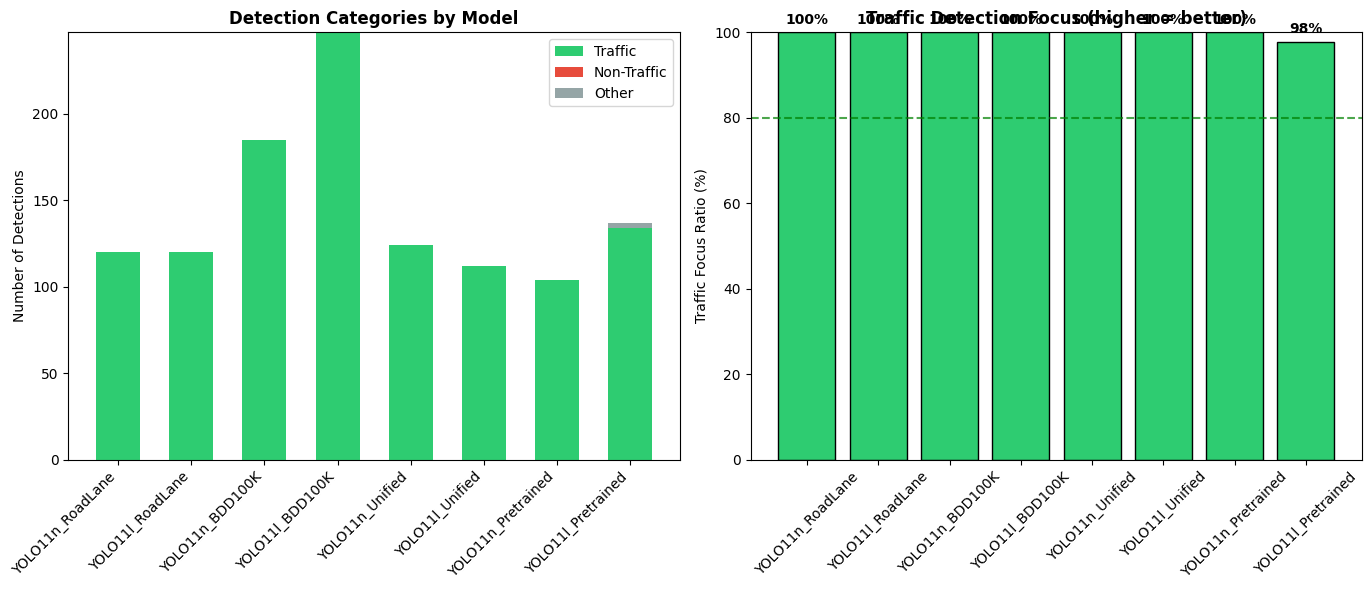

In [25]:
# Visualize detection relevance comparison
if relevance_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    models = list(relevance_results.keys())

    # Stacked bar chart: Traffic vs Non-Traffic detections
    ax = axes[0]
    traffic = [relevance_results[m]['traffic_count'] for m in models]
    non_traffic = [relevance_results[m]['non_traffic_count'] for m in models]
    other = [relevance_results[m]['other_count'] for m in models]

    x = np.arange(len(models))
    width = 0.6

    ax.bar(x, traffic, width, label='Traffic', color='#2ecc71')
    ax.bar(x, non_traffic, width, bottom=traffic, label='Non-Traffic', color='#e74c3c')
    ax.bar(x, other, width, bottom=[t+n for t,n in zip(traffic, non_traffic)],
           label='Other', color='#95a5a6')

    ax.set_ylabel('Number of Detections')
    ax.set_title('Detection Categories by Model', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()

    # Traffic Focus Ratio
    ax = axes[1]
    ratios = [relevance_results[m]['traffic_ratio'] * 100 for m in models]
    colors = ['#2ecc71' if r > 80 else '#f39c12' if r > 50 else '#e74c3c' for r in ratios]
    bars = ax.bar(models, ratios, color=colors, edgecolor='black')
    ax.set_ylabel('Traffic Focus Ratio (%)')
    ax.set_title('Traffic Detection Focus (higher = better)', fontweight='bold')
    ax.set_ylim(0, 100)
    ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Good (80%)')
    ax.tick_params(axis='x', rotation=45)

    for bar, ratio in zip(bars, ratios):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{ratio:.0f}%', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

## **Visual Comparison: Pre-trained vs Fine-tuned**

In [26]:
def compare_detections(image_path, models_dict, title="Detection Comparison"):
    """
    Compare detection results from multiple models on the same image.
    """
    n_models = len(models_dict)
    fig, axes = plt.subplots(1, n_models + 1, figsize=(5 * (n_models + 1), 5))

    # Original image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=11)
    axes[0].axis('off')

    # Detection results from each model
    for idx, (name, model) in enumerate(models_dict.items(), 1):
        results = model(image_path, verbose=False)
        annotated = results[0].plot()
        annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

        n_det = len(results[0].boxes)

        # Get detected classes
        detected_classes = []
        if n_det > 0:
            for cls_id in results[0].boxes.cls.cpu().numpy().astype(int):
                detected_classes.append(model.names[cls_id])

        axes[idx].imshow(annotated_rgb)
        axes[idx].set_title(f'{name}\n({n_det} detections)', fontsize=10)
        axes[idx].axis('off')

    plt.suptitle(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


Image 1: 20230619182008_247526_TS_3180_jpg.rf.f64a010e8d59ca999bdf0ce5936c4638.jpg


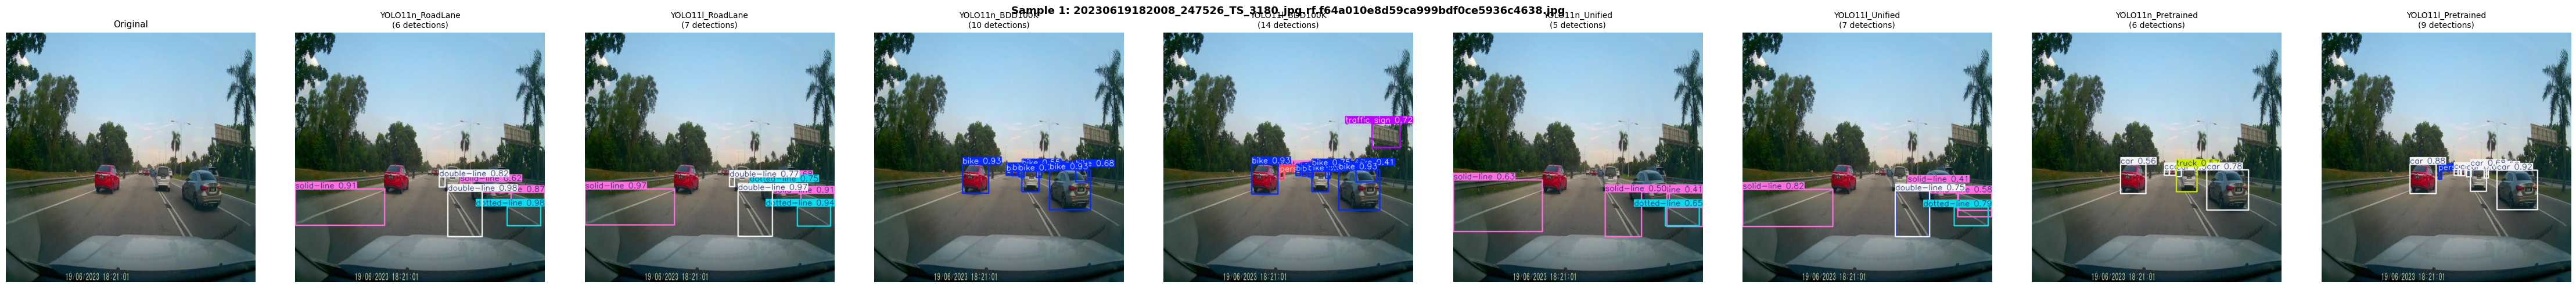


Image 2: Malaysia_Dash_Cam_Video_Compilation_14_Malaysian_Dash_Cam_Owners_mp4_6420_jpg.rf.c5d42726deb327834a73dda216d08c23.jpg


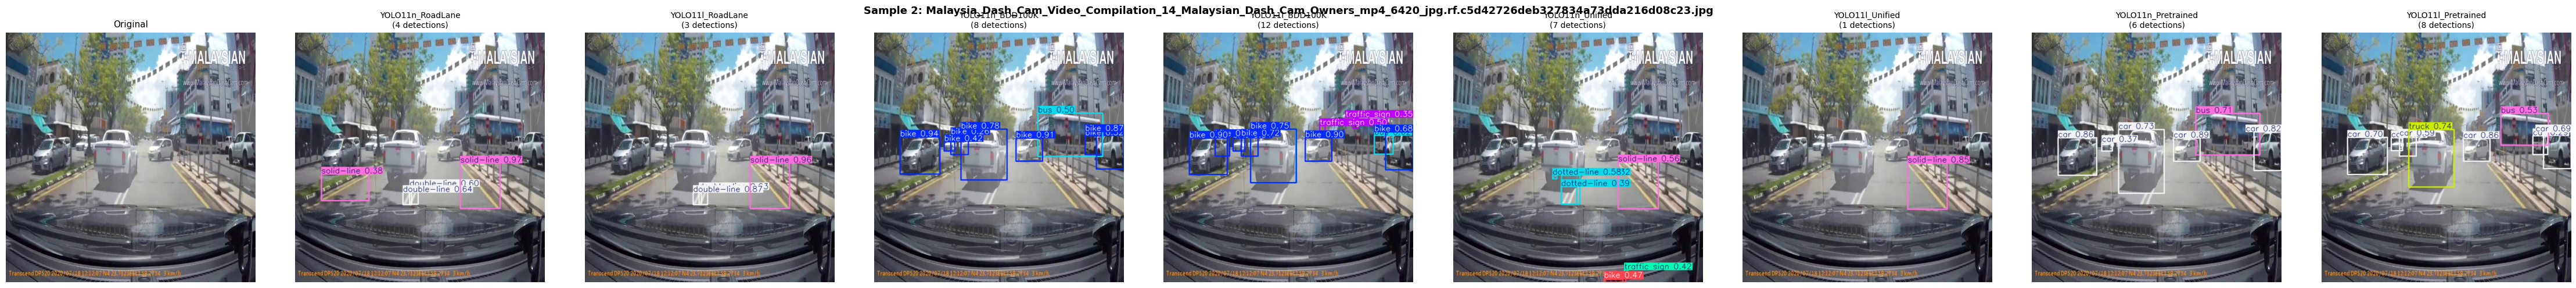


Image 3: 2023-06-15_14-15-54-front_mp4_420_jpg.rf.46b1287566d92afa7cb54cb45ebfb804.jpg


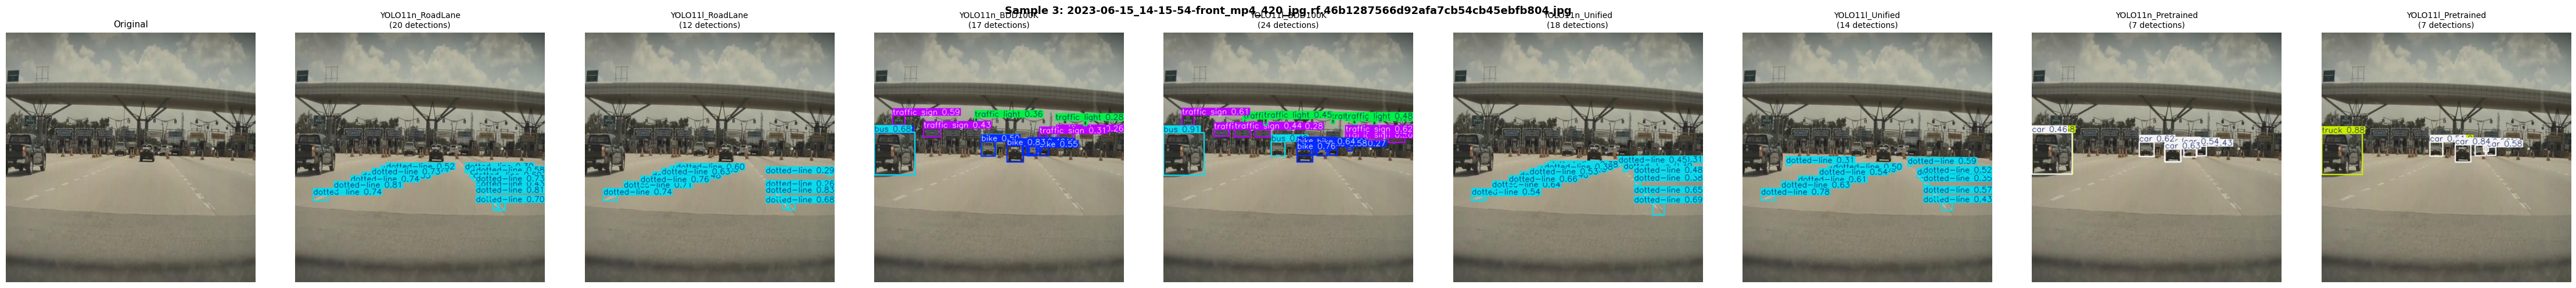

In [27]:
# Compare models on sample images
all_models = {}

for name, info in FINETUNED_MODELS.items():
    all_models[name] = info['model']

all_models.update(PRETRAINED_MODELS)

sample_images = all_test_images[:3] if all_test_images else test_images_lane[:3]

if sample_images:
    for i, img_path in enumerate(sample_images):
        print(f"\nImage {i+1}: {img_path.name}")
        compare_detections(img_path, all_models, f"Sample {i+1}: {img_path.name}")
else:
    print("No sample images found for comparison!")

## **Summary & Conclusions**

In [29]:
print("\nTRAINED MODELS")
for name, info in FINETUNED_MODELS.items():
    print(f"   {name}")
    print(f"      Classes: {len(info['classes'])}")
    print(f"      Path: {info['path']}")

print("\nPERFORMANCE HIGHLIGHTS")
if benchmark_results:
    fastest = min(benchmark_results.items(), key=lambda x: x[1]['avg_time_ms'])
    most_detections = max(benchmark_results.items(), key=lambda x: x[1]['avg_detections'])

    print(f"   Fastest: {fastest[0]} ({fastest[1]['fps']:.1f} FPS)")
    print(f"   Most detections: {most_detections[0]} ({most_detections[1]['avg_detections']:.1f} per image)")

print("\nDETECTION FOCUS")
if relevance_results:
    for name, result in relevance_results.items():
        status = "Good" if result['traffic_ratio'] > 0.8 else "Mixed" if result['traffic_ratio'] > 0.5 else "Poor"
        print(f"   {status} {name}: {result['traffic_ratio']:.1%} traffic-focused")


TRAINED MODELS
   YOLO11n_RoadLane
      Classes: 6
      Path: /kaggle/input/all-models/pytorch/default/1/yolo11n_road_lane/weights/best.pt
   YOLO11l_RoadLane
      Classes: 6
      Path: /kaggle/input/all-models/pytorch/default/1/yolo11l_road_lane/weights/best.pt
   YOLO11n_BDD100K
      Classes: 12
      Path: /kaggle/input/all-models/pytorch/default/1/yolo11n_bdd100k/weights/best.pt
   YOLO11l_BDD100K
      Classes: 12
      Path: /kaggle/input/all-models/pytorch/default/1/yolo11l_bdd100k/weights/best.pt
   YOLO11n_Unified
      Classes: 17
      Path: /kaggle/input/all-models/pytorch/default/1/yolo11n_unified/weights/best.pt
   YOLO11l_Unified
      Classes: 17
      Path: /kaggle/input/all-models/pytorch/default/1/yolo11l_unified/weights/best.pt

PERFORMANCE HIGHLIGHTS
   Fastest: YOLO11n_Pretrained (77.2 FPS)
   Most detections: YOLO11l_RoadLane (7.7 per image)

DETECTION FOCUS
   Good YOLO11n_RoadLane: 100.0% traffic-focused
   Good YOLO11l_RoadLane: 100.0% traffic-focused
  